In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [ ]:
import toml
from settings import PROJECT_ROOT
config = toml.load(os.path.join(PROJECT_ROOT, 'config.toml'))

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_white

In [5]:
df = load_pd_df("df_analysis.feather")
hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

# Cross Section Expectation and perception

In [268]:
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i ]) #and 'MY' not in i])
lst_error_cols = ['delta_pe_MY_error_act', 'pi_exp_MY_error_act', 'pi_perc_MY_error_act']

In [269]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)

delta_pe_MY_error_act (10768, 2)
pi_exp_MY_error_act (11052, 2)
pi_perc_MY_error_act (9145, 2)


In [270]:
dict_cols_pretty_names = {
    'delta_pe_MY_error_act': "$\~{\pi}^{\Delta e}_{t|t+12}$", 
    'delta_pe_MY_error_act_3': "$\~{\pi}^{\Delta e}_{t|t+12}$", 
    "pi_exp_MY_error_act": "$\~{\pi}^e_{t|t+12}$", 
    "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$"
}

In [271]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'eduschool_txt',
        'eduwork_txt',
        # 'wealth_bank_midpoint', 
        'savings_planned', 
        'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [272]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': float, 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO', 'eduschool_txt': 'category', 'savings_planned': float,
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [273]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col].dropna(), dtype=bool, ).add_prefix(col)
        _ = dummies.iloc[:, 1:]
        ols_data = ols_data.join(_)
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [274]:
# multiple ols models
lst_ols_mods, lst_dfbetas, lst_ols_data = [], [], []
_ = ""
for col in lst_error_cols + ['delta_pe_MY_error_act']:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    
    if col == "delta_pe_MY_error_act" and _ == "":
        d = d[[i for i in d.columns if 'saving' not in i]]
        _ = "x"
    else:
        d = d[[i for i in d.columns if 'risk' not in i]]
    d = d.dropna()
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    
    lst_ols_data.append((d[col], d.drop(col, axis=1), ols.predict(d.drop(col, axis=1))))
    
    # dfbeta = get_dfbetas(ols.model.exog, ols.resid.values)
    # lst_dfbetas.append((d, pd.DataFrame(dfbeta, index=d.index, columns=d.columns[:-1])))
    
    lst_ols_mods.append(ols)

In [275]:
out = get_statsmodels_summary(lst_ols_mods, seperator=" ", thresh_sig=.1, is_filt_sig=True)
save_pd_df(out, 'tab_cross_section_error.csv', GRAPHS_DIR)

out1 = get_statsmodels_summary(lst_ols_mods, seperator=" ", thresh_sig=.1, is_filt_sig=False)
save_pd_df(out1, 'tab_cross_section_error_appendix.csv', GRAPHS_DIR)

In [276]:
out

,delta_pe_MY_error_act,delta_pe_MY_error_act_3,pi_exp_MY_error_act,pi_perc_MY_error_act
const,-2.967 [-1.074],0.394 [0.978],-0.155 [-0.55],-0.972 *** [-12.502]
eduwork_txtBachelor abgeschlossen,0.195 [0.288],-0.603 * [-1.739],-0.567 ** [-2.295],-0.039 [-0.584]
eduwork_txtMaster abgeschlossen,-0.287 [-0.485],-0.523 * [-1.7],-0.447 ** [-2.041],0.018 [0.306]
eduwork_txtanderer Abschluss,-2.168 [-1.377],-0.549 [-1.014],-0.428 [-1.115],0.211 ** [2.026]
eduwork_txtberuflich-schulische Ausbildung abgeschlossen,-0.712 [-1.087],-0.577 * [-1.705],-0.427 * [-1.777],0.069 [1.077]
hhchildren1.0,-0.138 [-0.387],-0.027 [-0.154],0.035 [0.286],0.066 * [1.869]
is_food_shop,0.492 [0.846],-0.124 [-0.467],-0.019 [-0.101],0.088 * [1.697]
profession_txtArbeiter,0.942 * [1.807],-0.007 [-0.029],-0.063 [-0.355],0.024 [0.489]
savings_planned,NaN,0.278 ** [2.318],0.209 ** [2.461],0.072 *** [2.953]
N,364.0,1607.0,1663.0,1229.0


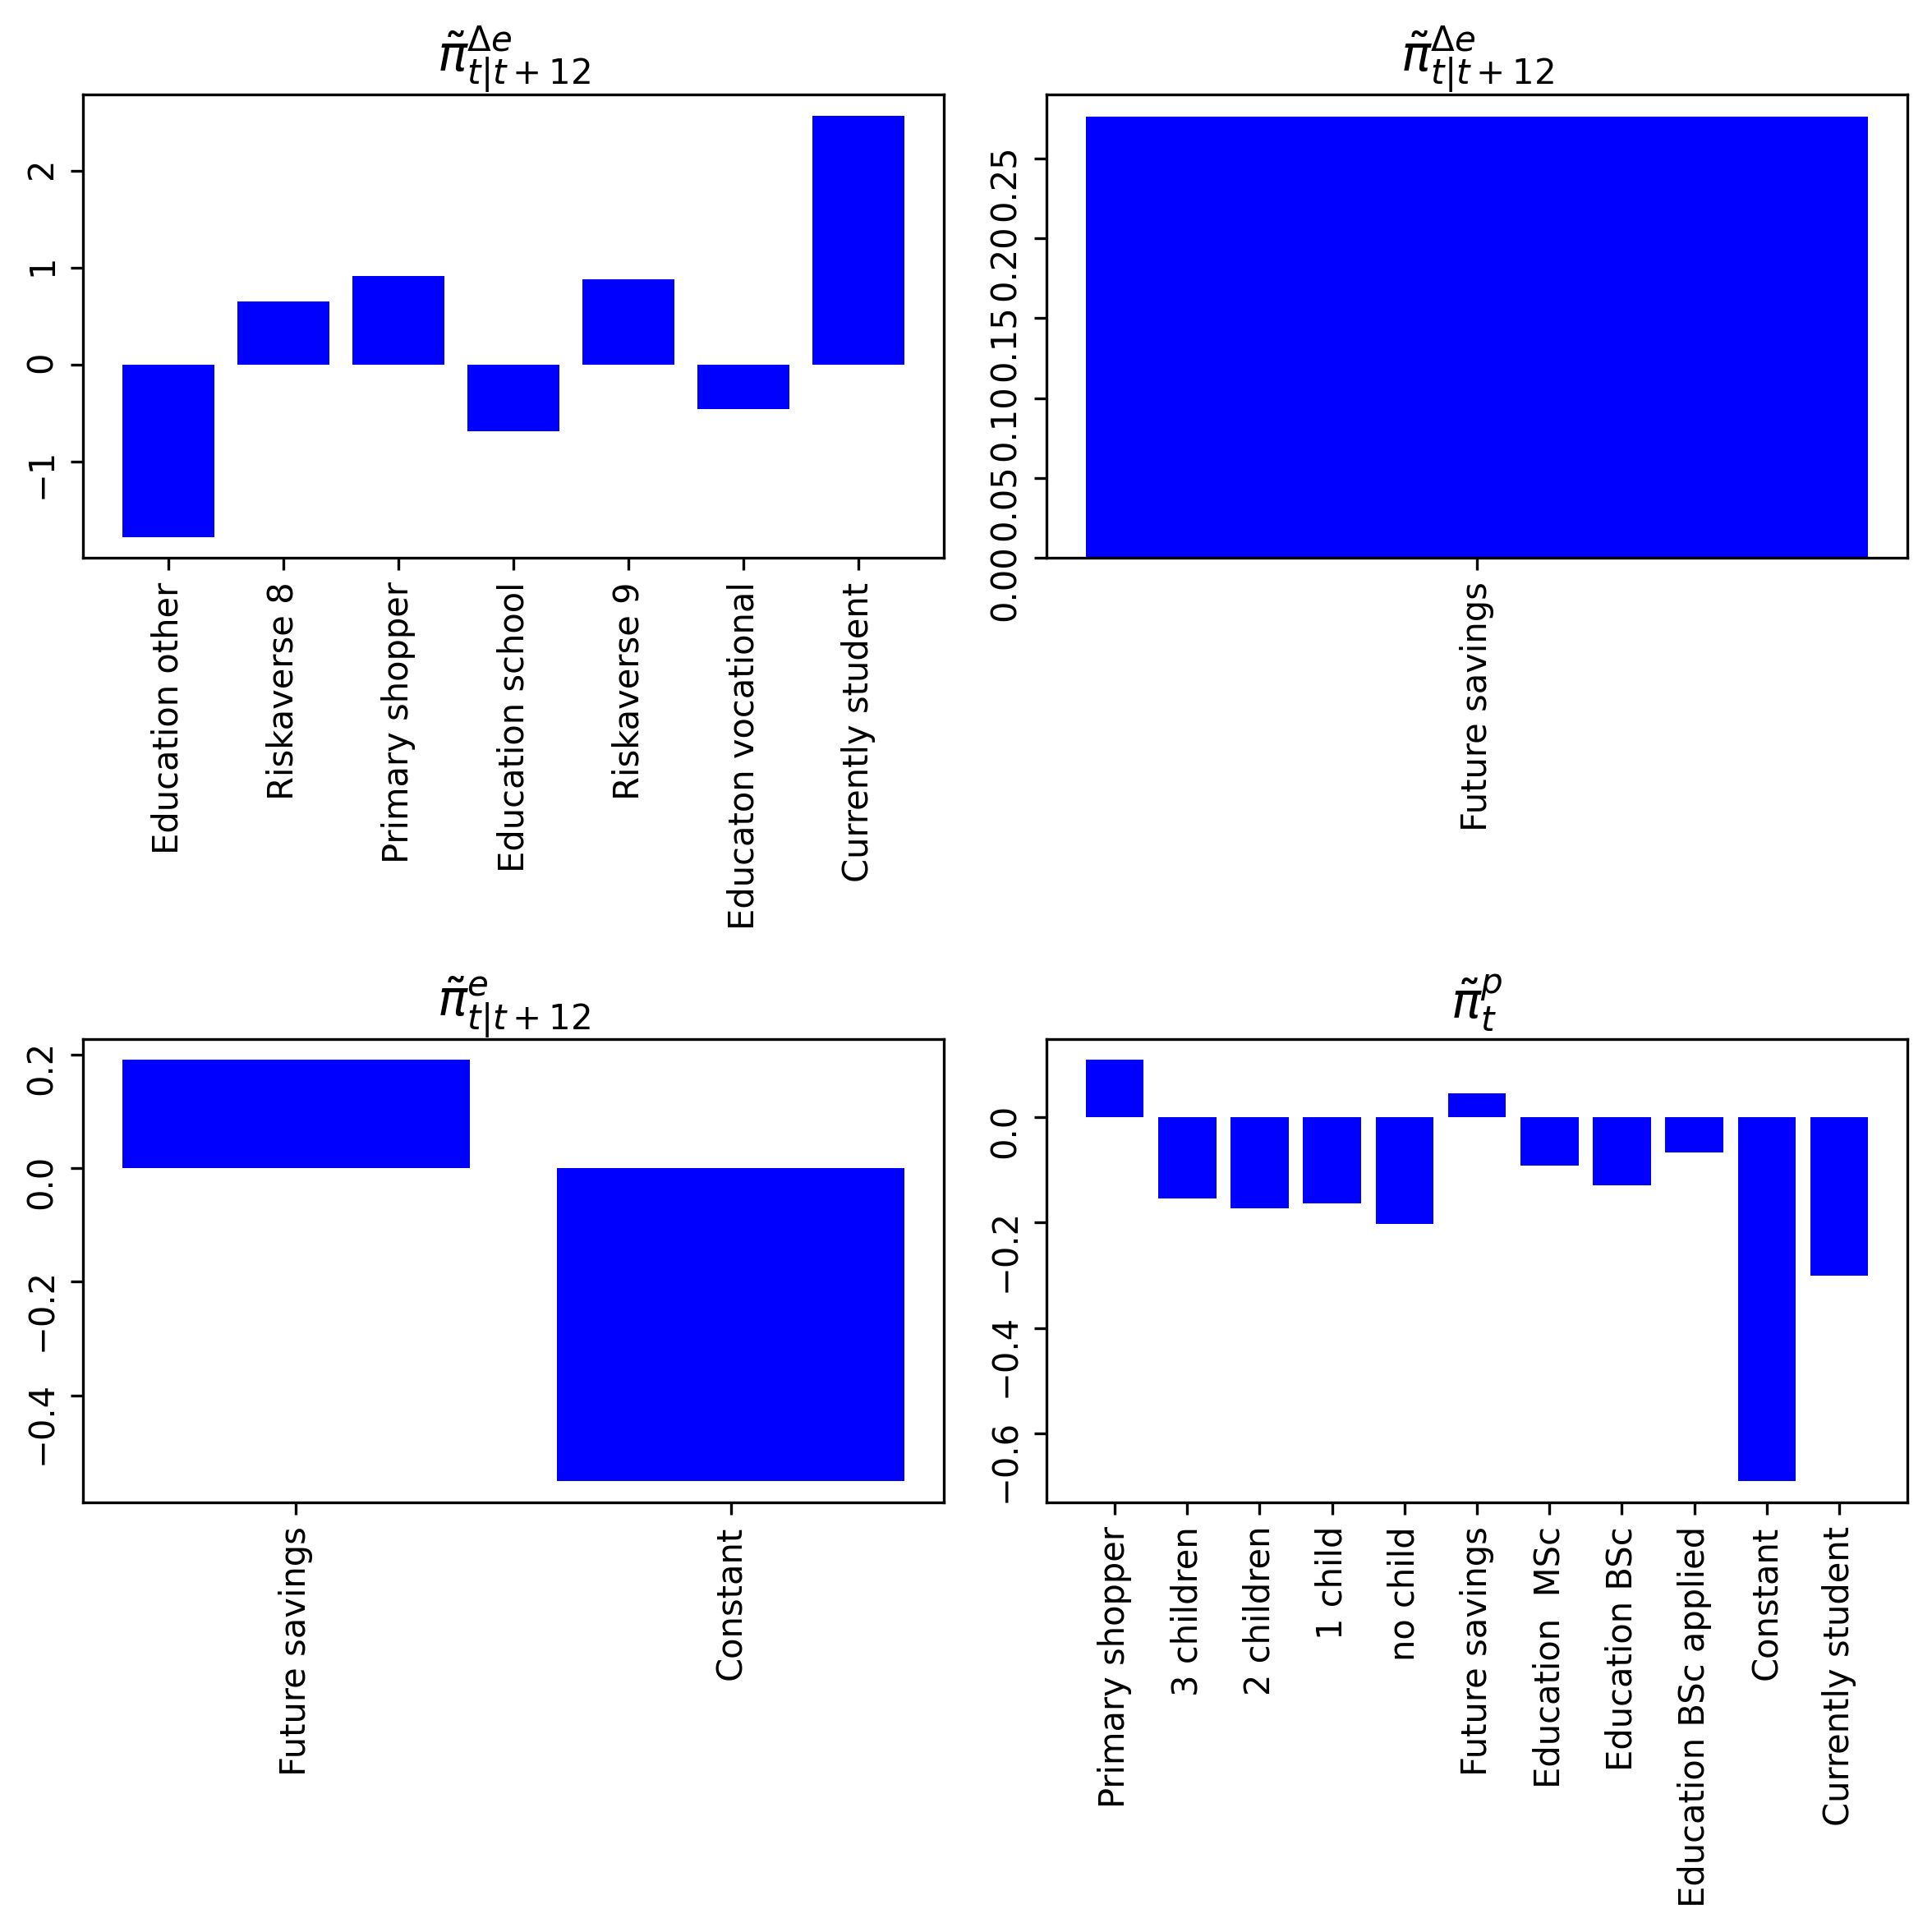

In [231]:
out = load_pd_df("tab_cross_section_error.csv", index_col="Unnamed: 0")
_dict = {}
fig, axes = plt.subplots(2, 2, figsize=(8,8), dpi=300)
for i, col in enumerate(out):
    ax = axes.ravel()[i]
    ax.tick_params(labelrotation=90, labelsize=10)
    ser = out[col]
    
    ser = ser[ser.apply(lambda x: len(str(x).split()) > 2)]
    res = ser.apply(lambda x: str(x).split()[0]).astype(float)
    # break
    ax.bar([config['var_names'][i] for i in res.index], res, color='blue')
    ax.set_title(dict_cols_pretty_names[col])
    
fig.tight_layout()
save_fig(fig, "fig_cross_coefs.png")

In [48]:
# plot QQ normal distribution for residuals

In [49]:
_dict =  {"delta_pe_MY_error_act": '$\~{\pi}^{\Delta e}$', "pi_perc_MY_error_act": "$\~{\pi}^p$", "pi_exp_MY_error_act": "$\~{\pi}^e$",
          "delta_pe_MY_error_act_1": '$\~{\pi}^{\Delta e}_1$',}

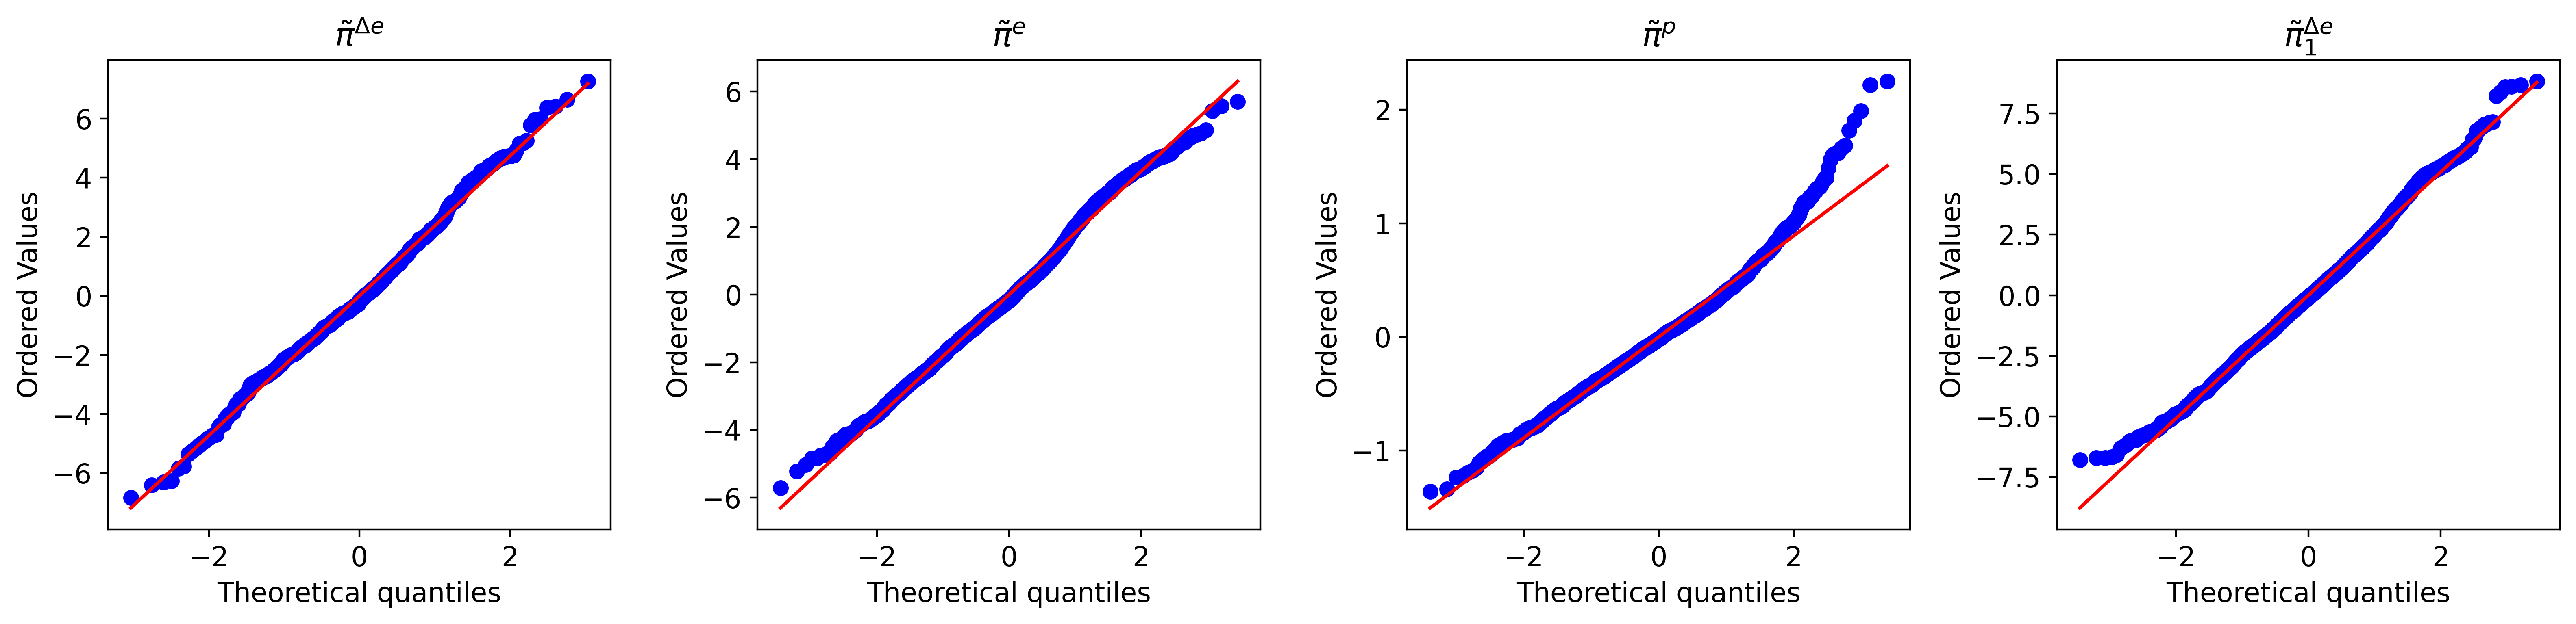

In [50]:
dict_het_white = {}
fig, axes = plt.subplots(1,len(lst_ols_mods), figsize=(16,4), dpi=400)
for i, mod in enumerate(lst_ols_mods):
    # axes.ravel()[i].hist(mod.resid.values, bins='fd', density=True,)
    
    kde = scipy.stats.gaussian_kde(mod.resid)
    _ = np.linspace(mod.resid.min(), mod.resid.max(), len(mod.resid))
    # axes.ravel()[i].plot(_, kde(_), color='green', label='kde estimate')
    
    scipy.stats.probplot(mod.resid, dist="norm", plot=axes.ravel()[i])
    
    _ = scipy.stats.normaltest(mod.resid.values)
    _ = het_white(mod.resid, lst_ols_data[i][1])
    name = mod.model.endog_names
    if name in dict_het_white.keys():
        name += "_1"
    dict_het_white[name] = dict(zip(['stat', 'pval', 'f-stat', 'f-pval',], _))
    axes.ravel()[i].set_title(_dict[name]) # + "\n" + f"Het white: homoscedasticity (5% sig) {_}")
    
    # axes.ravel()[i].legend(loc='upper left')
fig.tight_layout()
save_fig(fig, "fig_cross_qq.png")

In [51]:
# test for homoscedasticity

In [52]:
out = pd.DataFrame(dict_het_white).T
out['N'] = [len(i.resid) for i in lst_ols_mods]
out['print'] = out.apply(lambda x: str(x['pval'].round(3)) + get_stars(x['pval']) + "\n" + "[" + str(x['stat'].round(3)), axis=1)+"]"

save_pd_df(out[['N', 'print']].T, "tab_cross_homoscedasticity.csv")

In [53]:
out

,stat,pval,f-stat,f-pval,N,print
delta_pe_MY_error_act,207.092420,0.003874,1.505363,0.000694,581,0.004***\n[207.092]
pi_exp_MY_error_act,96.982409,0.082774,1.235941,0.079970,2604,0.083*\n[96.982]
pi_perc_MY_error_act,111.496395,0.007673,1.454476,0.006583,1967,0.008***\n[111.496]
delta_pe_MY_error_act_1,92.240294,0.129247,1.189025,0.126351,2517,0.129\n[92.24]


## risk aversion delta_pe

In [244]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]
sub2.index = [int(float(i.split('riskaversion')[-1])) for i in sub2.index]

sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
mean = sub.delta_pe_MY_error_act.mean()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)
sub.index = [int(float(i)) for i in sub.index]

sub = sub.join(sub2)

In [245]:
sub3 = df[['id', 'riskaversion', 'savings_planned']].dropna().copy()
sub3['savings_planned'] = sub3['savings_planned'].replace({1: 0}) * -1

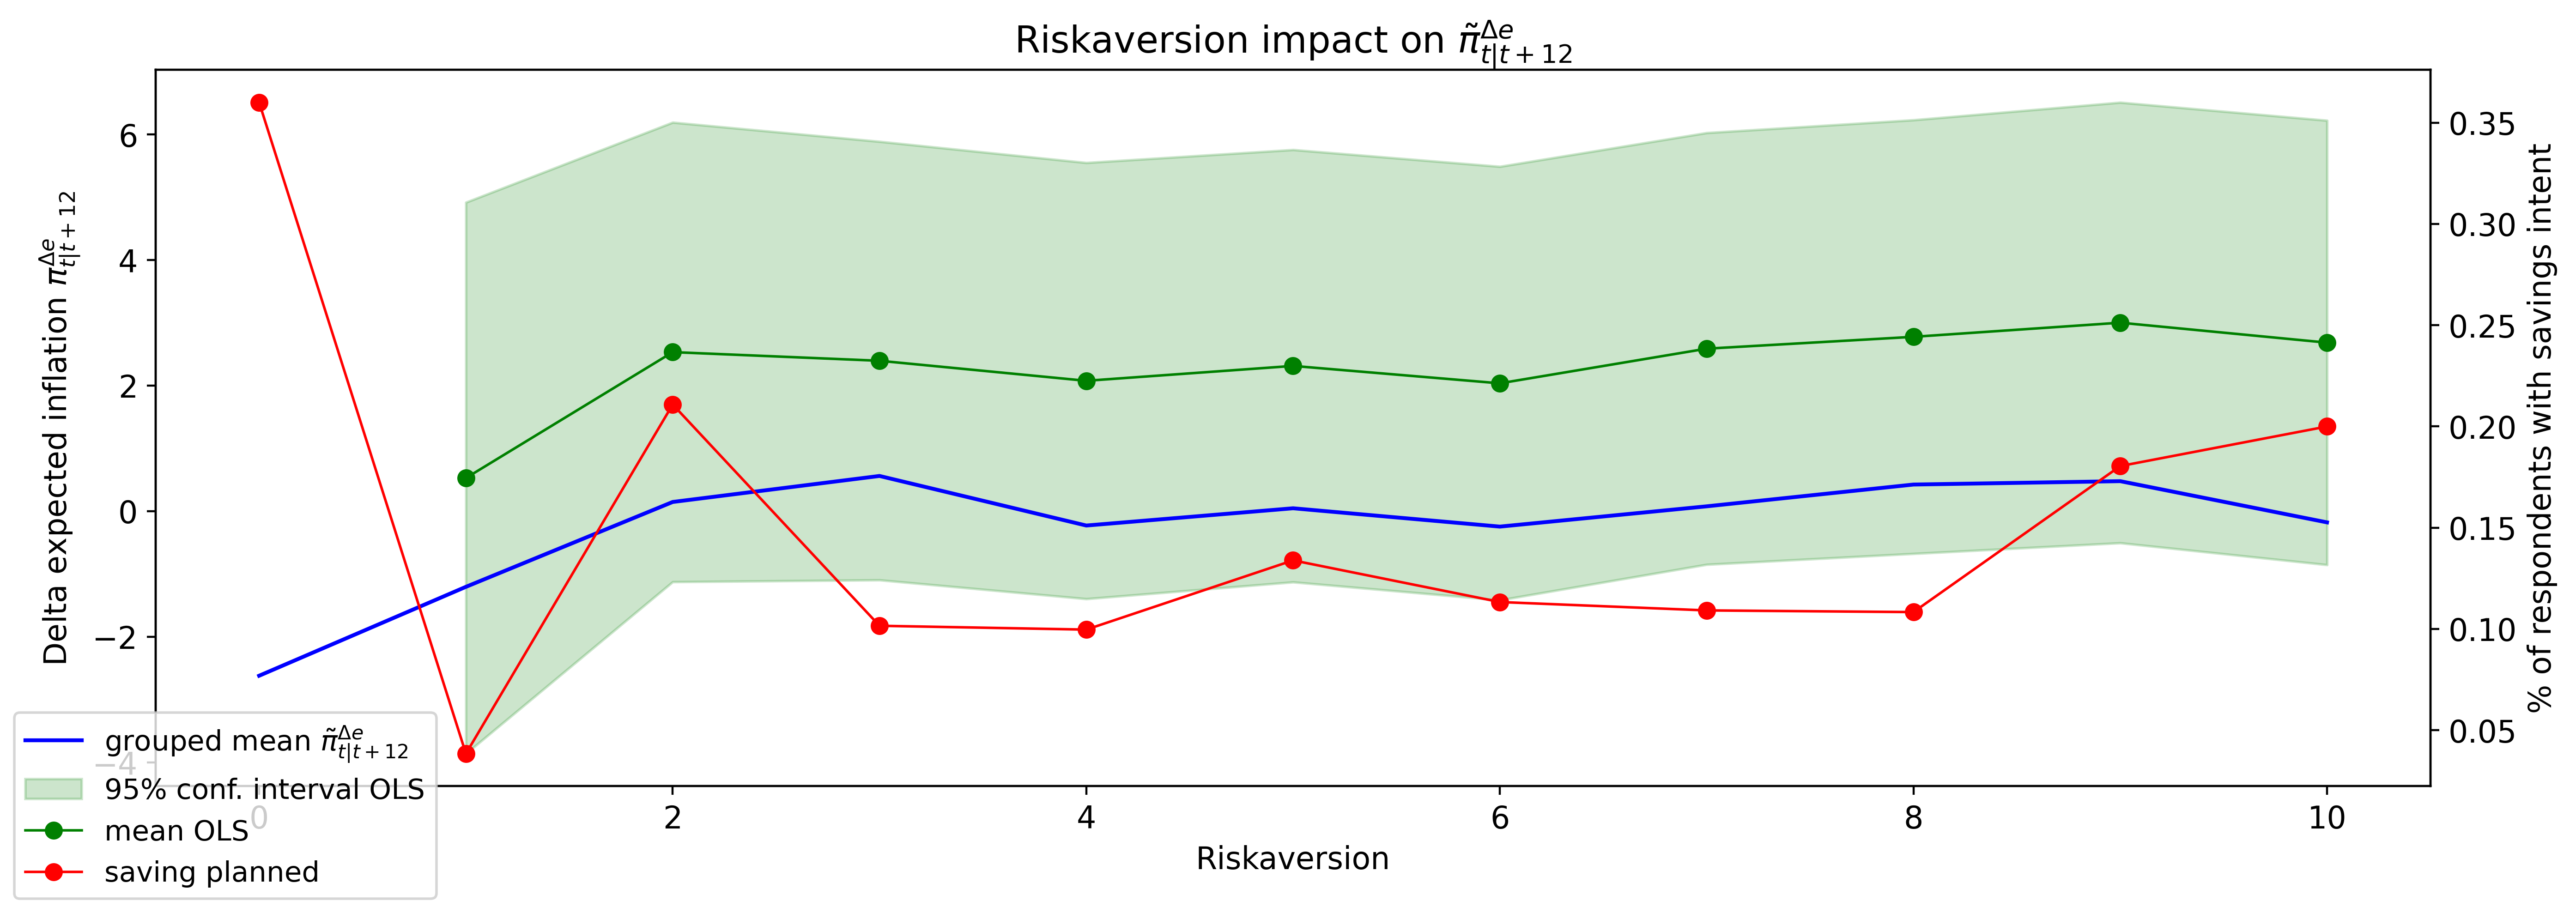

In [247]:
fig, ax = get_fig_subplots(figsize=(14,5), dpi=400)
ax.plot(sub['mean'], color='blue', label='grouped mean $\~{\pi}^{\Delta e}_{t|t+12}$')
ax.fill_between(sub.index, sub['conf_lower'], sub['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub['coef'], lw=1, marker='o', color='green', label='mean OLS')
# ax.plot(sub.index, list([0] * len(sub2)), color='black', lw=1,)
# ax.plot(sub.index, list([mean] * len(sub)), label='global $\~{\pi}^{\Delta e}_{t|t+12}$ mean', color='blue', linestyle='dashed')

ax2 = ax.twinx()
ax2.plot(sub3.groupby('riskaversion').savings_planned.mean(), color='red', lw=1, marker='o', label='saving planned')

ax.set_xlabel("Riskaversion")
ax2.set_ylabel("% of respondents with savings intent")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")
ax.set_title("Riskaversion impact on $\~{\pi}^{\Delta e}_{t|t+12}$")

fig.legend(loc='lower left', prop={'size': 11})

fig.tight_layout()
save_fig(fig, "riskaversion.png", GRAPHS_DIR)